# Basic Multi-agent Collaboration

This is an example accessed directly from [LangChain](https://www.langchain.com/) under the MIT License. All rights and credit go to the LangChain team. This example is being accessed for educational purposes only.

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools.

One way to approach complicated tasks is through a "divide-and-conquer" approach: create a specialized agent for each task or domain and route tasks to the correct "expert".

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.

Before we get started, a quick note: this and other multi-agent notebooks are designed to show _how_ you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = os.getenv("LANGCHAIN_TRACING_V2")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

## Create Agents

The following helper functions will help create agents. These agents will then be nodes in the graph.

You can skip ahead if you just want to see what the graph looks like.

In [2]:
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are a helpful AI assistant, collaborating with other assistants. Use your provided tool to progress towards answering the question. ONLY make one tool call per execution, and ONLY use your provided tool. If you are unable to fully answer, that's OK, another assistant with a different tool will help where you left off. Execute what you can to make progress. You have access to the following tools: {tool_names}.\n{system_message}""",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

## Define tools

We will also define some tools that our agents will use in the future

In [3]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

/var/folders/gy/sbcddtsn26j7wbzcnj0sz5zw0000gp/T/ipykernel_19752/568887837.py:6: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define State

We first define the state of the graph. This will just a list of messages, along with a key to track the most recent sender

In [4]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Define Agent Nodes

We now need to define the nodes. First, let's define the nodes for the agents.

In [5]:
import functools
from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o-mini")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You provide accurate data for the chart_generator agent to use. DO NOT attempt to generate the chart. You ONLY have access to the tavily_tool. ONLY use this search tool. When you have all of the required data, stop making tool calls and allow the team to continue with the chart_generator agent.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user. Only consider the task completed when you have a well-organized chart displaying all of the data requested. If you cannot create a chart with all of the requested data, allow the team to continue doing research with the Researcer agent. When you have the deliverable, prefix your response with FINAL ANSWER so the team knows to stop.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

### Define Tool Node

We now define a node to run the tools

In [6]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

### Define Edge Logic

We can define some of the edge logic that is needed to decide what to do based on results of the agents

In [7]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

### Define the Graph

We can now put it all together and define the graph!

In [8]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

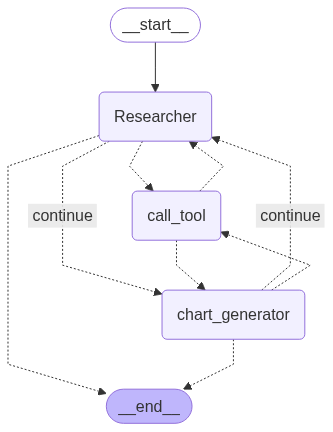

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

/var/folders/gy/sbcddtsn26j7wbzcnj0sz5zw0000gp/T/ipykernel_19752/192370608.py:12: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WfJLvzrExCddBotV71ewQw0m', 'function': {'arguments': '{"query":"United States GDP historical data last 25 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 259, 'total_tokens': 285, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BoBNryhiyhz4KCTwejhbZzchjCfa5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run--36708822-0d7a-4c1c-afe3-60095b2ded8d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'United States GDP historical data last 25 years'}, 'id'

/var/folders/gy/sbcddtsn26j7wbzcnj0sz5zw0000gp/T/ipykernel_19752/192370608.py:12: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4oh1QsVIjuahGqceTrn6kbwJ', 'function': {'arguments': '{"query": "US GDP 1998 to 2022"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_toCyew89NXRqV0uUemLRxiGa', 'function': {'arguments': '{"query": "US GDP 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 1403, 'total_tokens': 1467, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BoBNuJvSEmnr9rGZk8FklXT5DtrQZ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run--7216c27f-940f-4582-8179-3f357c0855f3-

/var/folders/gy/sbcddtsn26j7wbzcnj0sz5zw0000gp/T/ipykernel_19752/192370608.py:12: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='I have gathered the GDP data for the United States over the last 25 years. Here are the GDP values in trillions of USD:\n\n- **1998**: 9.062\n- **1999**: 9.631\n- **2000**: 10.251\n- **2001**: 10.582\n- **2002**: 10.929\n- **2003**: 11.456\n- **2004**: 12.217\n- **2005**: 13.039\n- **2006**: 13.816\n- **2007**: 14.477\n- **2008**: 14.770\n- **2009**: 14.478\n- **2010**: 15.049\n- **2011**: 15.600\n- **2012**: 16.254\n- **2013**: 16.843\n- **2014**: 17.551\n- **2015**: 18.206\n- **2016**: 18.695\n- **2017**: 19.477\n- **2018**: 20.533\n- **2019**: 21.381\n- **2020**: 21.354\n- **2021**: 23.681\n- **2022**: 26.007\n- **2023**: 27.721\n\nWith this data, the next step would be to generate a bar graph with red bars representing the GDP values for these years. \n\nI will now pass the data to the chart_generator agent for the creation of the graph.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 359

/var/folders/gy/sbcddtsn26j7wbzcnj0sz5zw0000gp/T/ipykernel_19752/192370608.py:12: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nHtsAppOXTxLeR30ja5d5SeU', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Years and corresponding GDP values in trillions\\nyears = [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]\\ngdp_values = [9.062, 9.631, 10.251, 10.582, 10.929, 11.456, 12.217, 13.039, 13.816, 14.477, 14.770, 14.478, 15.049, 15.600, 16.254, 16.843, 17.551, 18.206, 18.695, 19.477, 20.533, 21.381, 21.354, 23.681, 26.007, 27.721]\\n\\n# Create a bar graph\\nplt.figure(figsize=(12,6))\\nplt.bar(years, gdp_values, color=\'red\')\\nplt.title(\'United States GDP Over the Past 25 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP in Trillions of USD\')\\nplt.xticks(years, rotation=45)\\nplt.grid(axis=\'y\')\\n\\n# Show the chart\\nplt.tight_layout()\\nplt.show()"}', 'name': 'python_repl

Matplotlib is building the font cache; this may take a moment.


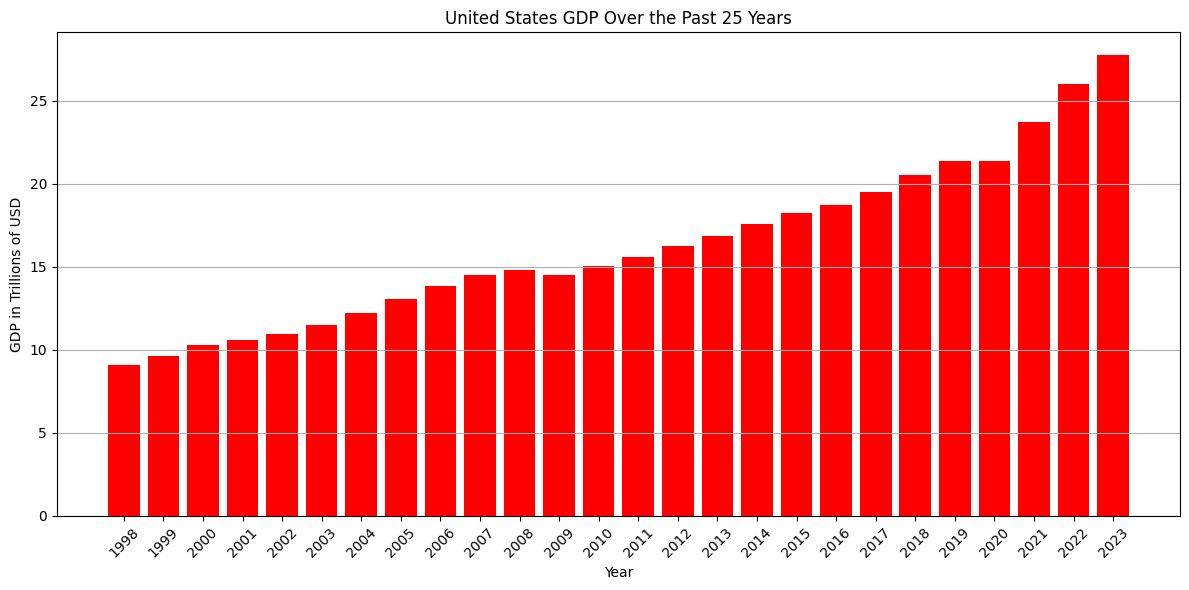

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# Years and corresponding GDP values in trillions\nyears = [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]\ngdp_values = [9.062, 9.631, 10.251, 10.582, 10.929, 11.456, 12.217, 13.039, 13.816, 14.477, 14.770, 14.478, 15.049, 15.600, 16.254, 16.843, 17.551, 18.206, 18.695, 19.477, 20.533, 21.381, 21.354, 23.681, 26.007, 27.721]\n\n# Create a bar graph\nplt.figure(figsize=(12,6))\nplt.bar(years, gdp_values, color='red')\nplt.title('United States GDP Over the Past 25 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP in Trillions of USD')\nplt.xticks(years, rotation=45)\nplt.grid(axis='y')\n\n# Show the chart\nplt.tight_layout()\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_nHtsAppOXTxLeR

/var/folders/gy/sbcddtsn26j7wbzcnj0sz5zw0000gp/T/ipykernel_19752/192370608.py:12: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


In [10]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the United State's GDP over the past 25 years,"
                " then chart a bar graph with red bars of it."
                " Once the chart is displayed to the user, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 25},
)
for s in events:
    print(s)
    print("----")